# Importacion y limpieza

In [1]:
#Importamos todo lo necesario
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#definimos el DataFrame
data = pd.read_excel('/content/indice_brent.xlsx', index_col=0)
print(data.head())

             Open   High    Low Close* Adj Close** Volume
Date                                                     
2023-05-29      -      -      -      -           -      -
2023-05-26  76.12  77.35  75.72  76.95       76.95  36272
2023-05-25  78.26   78.5  75.12  76.26       76.26  36272
2023-05-24  77.59  78.66  77.04  78.36       78.36  33849
2023-05-23  75.97  77.74  75.65  76.84       76.84  30676


In [3]:
#Chequeamos cuandos valores estan vacios por dias no abrio el mercado
data[data['Adj Close**'] == '-'].count()

Open           13
High           13
Low            13
Close*         13
Adj Close**    13
Volume         13
dtype: int64

In [4]:
#Sacamos las filas para las que no poseemos datos
data = data.drop(data[data['Adj Close**'] == '-'].index)

In [5]:
#Verificamos que ahora no hay valores vacios
data[data['Adj Close**'] == '-'].count()

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [6]:
#Cambio de tipo de una columna de forma auxiliar
data['Adj Close**'] = data['Adj Close**'].astype(float)

data = data.sort_index(ascending=True)
print(data.tail())

serie = data['Adj Close**']
print(serie)

             Open   High    Low Close*  Adj Close** Volume
Date                                                      
2023-05-22  75.74  76.46  74.55  75.99        75.99  22801
2023-05-23  75.97  77.74  75.65  76.84        76.84  30676
2023-05-24  77.59  78.66  77.04  78.36        78.36  33849
2023-05-25  78.26   78.5  75.12  76.26        76.26  36272
2023-05-26  76.12  77.35  75.72  76.95        76.95  36272
Date
2015-01-02    56.42
2015-01-05    53.11
2015-01-06    51.10
2015-01-07    51.15
2015-01-08    50.96
              ...  
2023-05-22    75.99
2023-05-23    76.84
2023-05-24    78.36
2023-05-25    76.26
2023-05-26    76.95
Name: Adj Close**, Length: 2111, dtype: float64


# Exploración de la serie

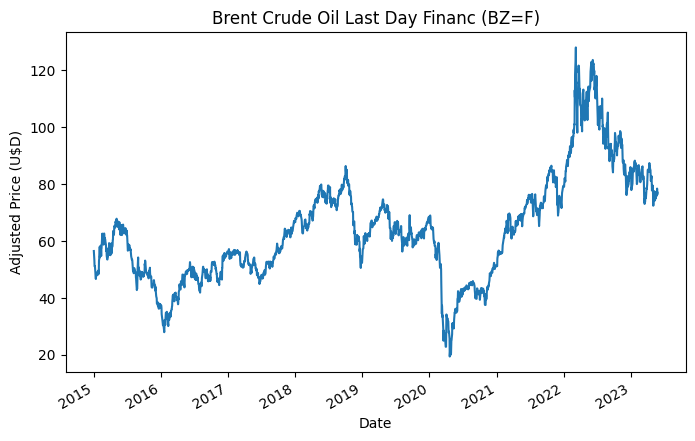

In [7]:
#Graficamos la serie
plt.figure(figsize=(8,5))
serie_plot = serie.plot()
serie_plot.set_ylabel('Adjusted Price (U$D)')
serie_plot.set_xlabel('Date')
serie_plot.set_title('Brent Crude Oil Last Day Financ (BZ=F)')
plt.show()

Podemos intuir que la serie es no estacionaria pero no estaremos seguros hasta hacer los correspondientes tests

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


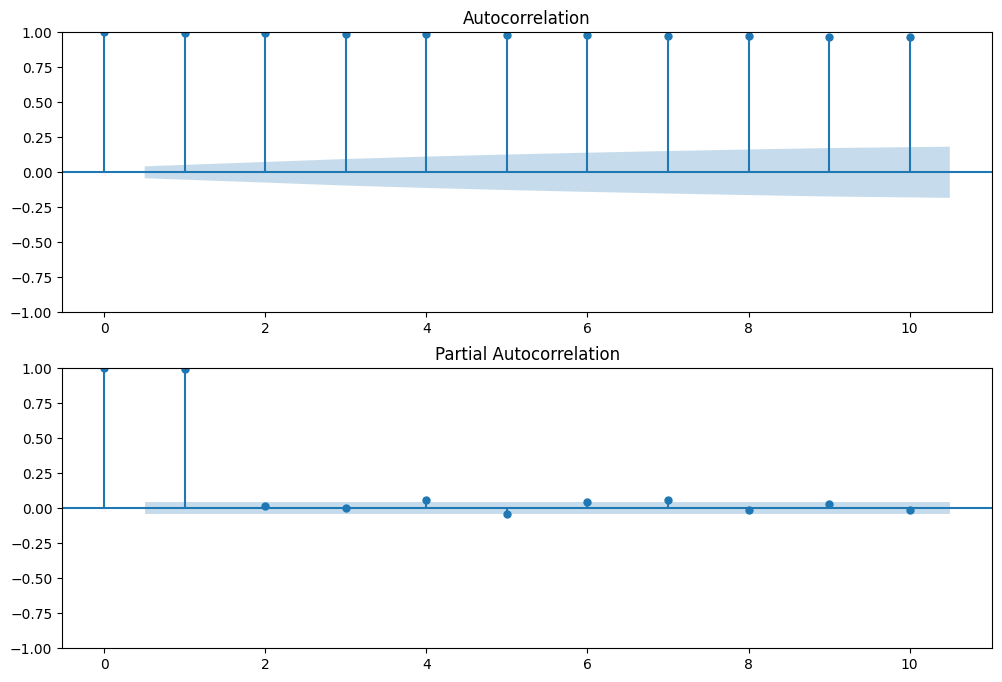

In [8]:
#Graficos de autocorrelacion y acutocorrelacion parcial de la serie
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(serie, lags=10, ax=ax1)
plot_pacf(serie, lags=10, ax=ax2)
plt.show()

Vemos que la autocorrelacion decrece linealmente, podemos inferir junto con la tendencia de las serie que no es estacionaria

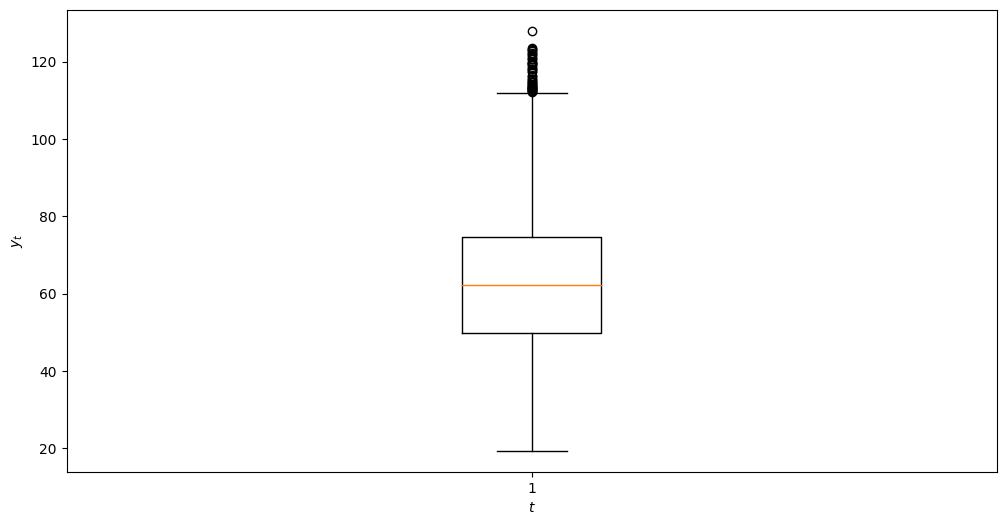

La media de la serie es 63.71620085267644
La varianza de la serie es 352.4629461283595
La curtosis de la serie es 0.44677254107988773
La asimetria de la serie es 0.6516627502357732
Percentiles:
 [ 19.33   27.703  30.882  33.297  35.112  37.205  39.266  40.267  41.118
  41.938  42.78   43.242  43.792  44.43   45.026  45.715  46.256  46.851
  47.334  47.735  48.13   48.42   48.742  49.036  49.288  49.725  50.238
  50.647  50.968  51.499  51.9    52.284  52.85   53.792  54.354  55.
  55.39   55.697  55.928  56.259  56.66   57.371  57.968  58.542  59.148
  59.915  60.436  60.907  61.466  61.928  62.2    62.512  62.918  63.313
  63.6    63.95   64.356  64.711  65.118  65.488  66.11   66.491  66.762
  67.203  67.848  68.48   69.02   69.46   70.364  71.068  71.73   72.253
  72.866  73.456  74.016  74.645  75.056  75.467  76.17   76.944  77.62
  78.525  79.28   79.955  81.222  82.295  83.108  84.289  84.924  85.983
  87.62   90.476  92.832  94.426  96.744 100.125 105.05  107.646 112.018
 116.2

In [9]:
#Calculo de diferentes medidas estadisticas de relevancia y grafico de BoxPlot
media_serie=serie.mean()
varianza_serie=serie.var()
curtosis_serie=serie.kurtosis()
asimetria_serie=serie.skew()
percentil = np.percentile(serie, range(0,101,1))

plt.figure(figsize=(12,6))
plt.boxplot(serie)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()


print("La media de la serie es", media_serie)
print("La varianza de la serie es", varianza_serie)
print("La curtosis de la serie es", curtosis_serie)
print("La asimetria de la serie es", asimetria_serie)
print("Percentiles:\n", format(percentil))

[]

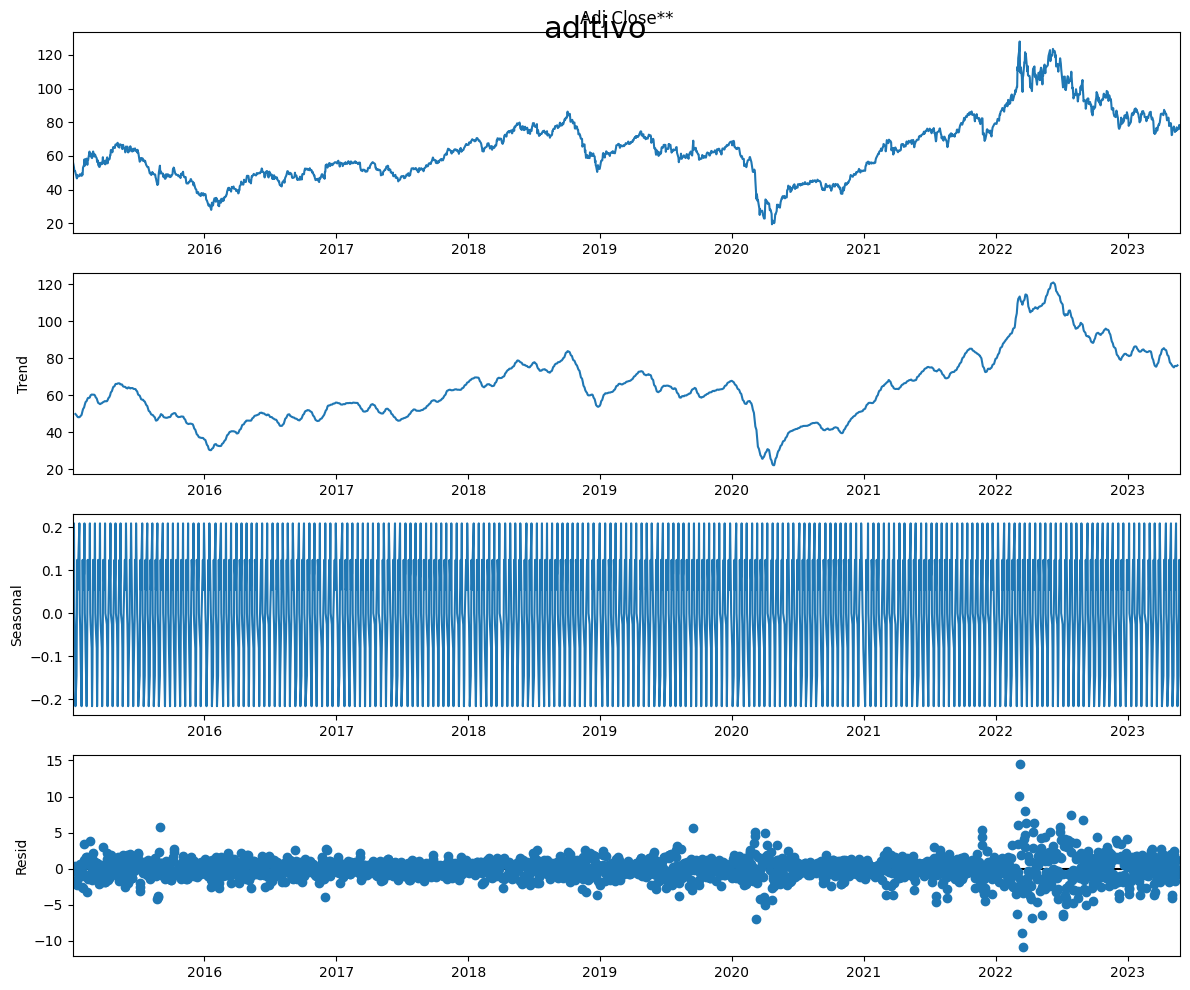

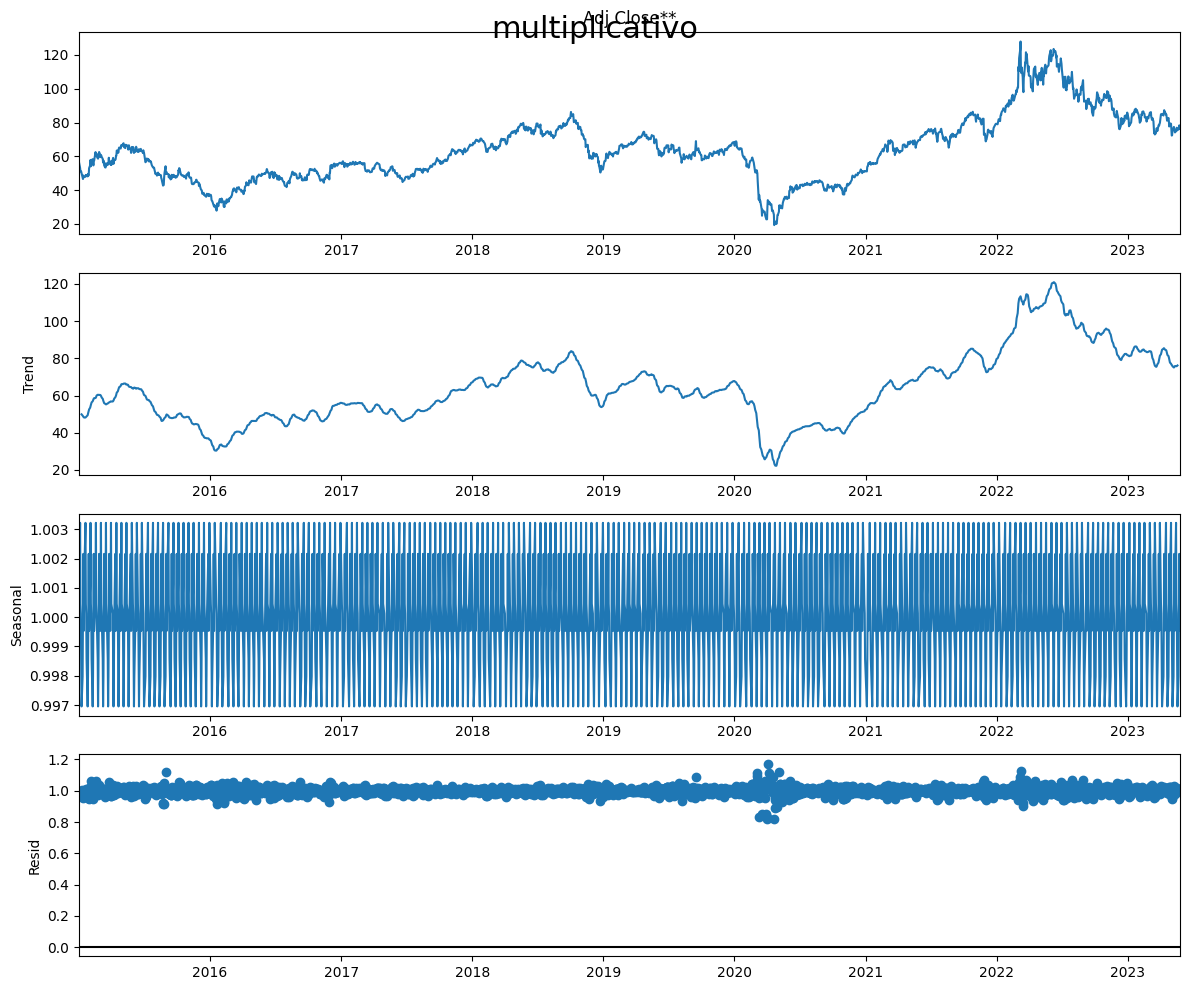

In [10]:
#Descomposicion de estacionalidad de la serie
decomposition_add = seasonal_decompose(serie, model='additive', period=10)
decomposition_multi = seasonal_decompose(serie, model='multiplicative',period=10)

plt.rcParams.update({'figure.figsize':(12,10)})
decomposition_add.plot().suptitle('aditivo', fontsize=22)
decomposition_multi.plot().suptitle('multiplicativo', fontsize=22)
plt.plot()

In [11]:
#Hacemos el test de dickey-fuller
testing = adfuller(serie)
testing

(-1.766379879628222,
 0.3972762112637577,
 6,
 2104,
 {'1%': -3.4334618327378696,
  '5%': -2.8629146774725713,
  '10%': -2.5675018132490712},
 7976.532156015082)

Vemos que como el p-value es grande, no rechazamos H0. No es estacionaria la serie.

In [12]:
#Diferenciamos la serie
serie = pd.DataFrame(serie)
serie_dif = serie.diff().dropna()

In [13]:
#Celda auxiliar
serie_dif = serie_dif.astype(float)

<Figure size 800x500 with 0 Axes>

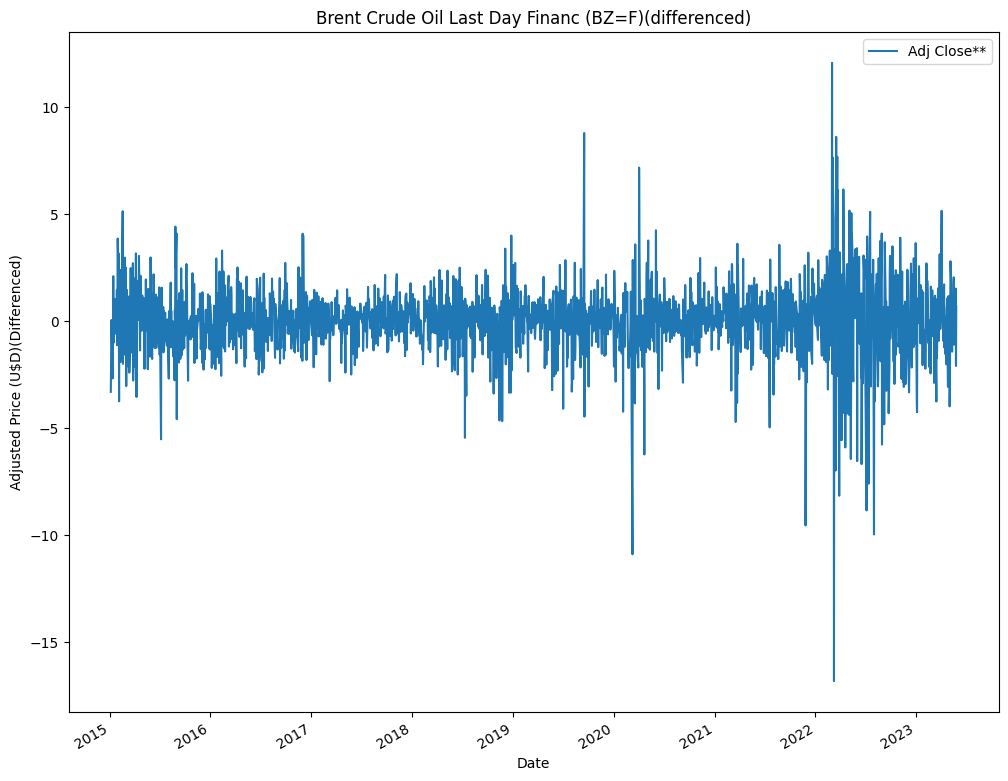

In [14]:
#Gradico de la serie diferenciada
plt.figure(figsize=(8,5))
serie_dif_plot = serie_dif.plot()
serie_dif_plot.set_ylabel('Adjusted Price (U$D)(Differenced)')
serie_dif_plot.set_xlabel('Date')
serie_dif_plot.set_title('Brent Crude Oil Last Day Financ (BZ=F)(differenced)')
plt.show()

vemos que se ha vuelto estacionaria en torno a la media

Text(0.5, 1.0, 'Función de autocovarianzas')

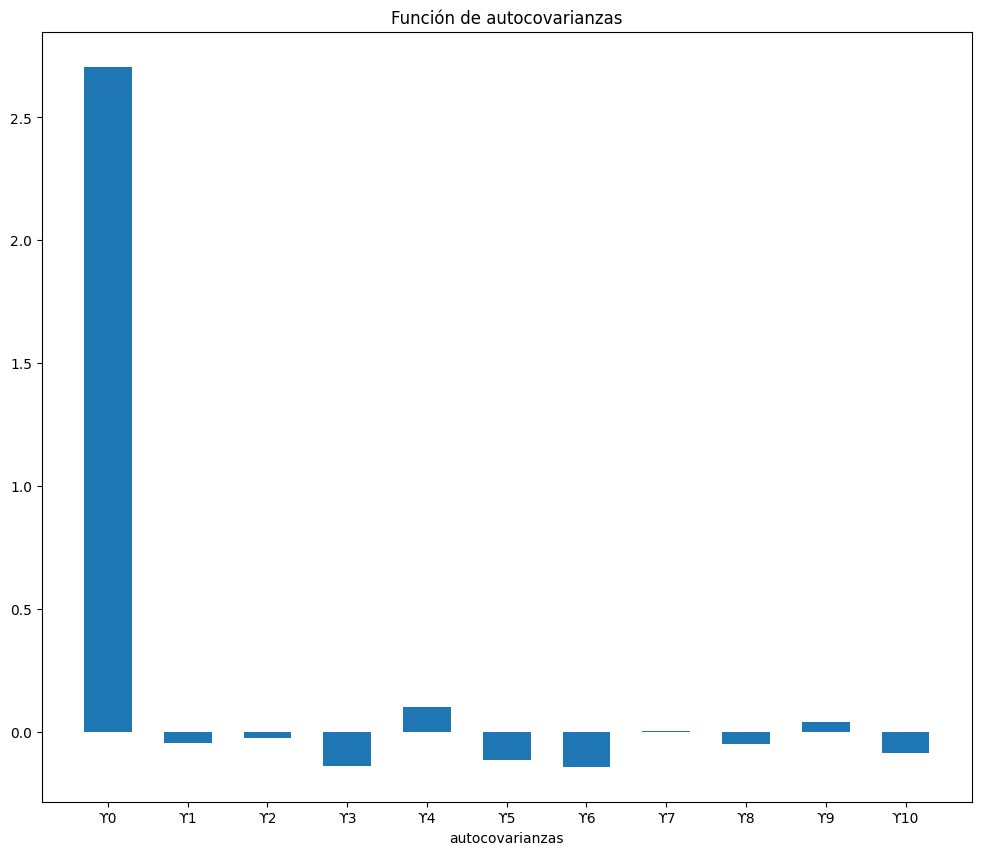

In [15]:
#Grafico de autocovarianzas
fas = acovf(serie_dif, nlag=10)
a=[i for i in range(len(fas))]
b=['ϒ{}'.format(i) for i in range(len(fas))]
plt.bar(a, fas, tick_label=b, width=0.6)
plt.xlabel('autocovarianzas')
plt.title("Función de autocovarianzas")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


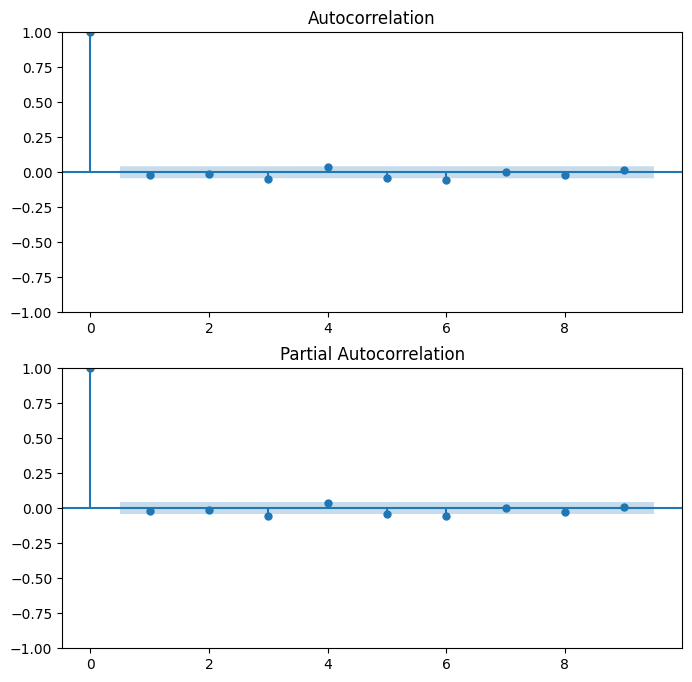

In [16]:
#Autocorrelacion y autocorrelacion parcial de la serie diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(serie_dif, lags=9, ax=ax1)
plot_pacf(serie_dif, lags=9, ax=ax2)
plt.show()

In [17]:
#Test de dickey-fuller de la serie diferenciada
test_df = adfuller(serie_dif)
test_df

(-20.75293627298755,
 0.0,
 5,
 2104,
 {'1%': -3.4334618327378696,
  '5%': -2.8629146774725713,
  '10%': -2.5675018132490712},
 7973.279076658398)

Como el p-value es muy chico, se rechaza H0, por lo que sabemos que la serie se vuelve estacionaria con la primera diferencia.

#Selección del modelo


In [18]:
order_aic_bic = []
# Bucle para probar diferentes valores de p y q
for p in range(4):
    for q in range(4):
        try:
            # Ajustar el modelo ARIMA(p, 1, q)
            model = ARIMA(serie, order=(p, 1, q))
            result = model.fit()
            order_aic_bic.append((p, q, result.aic, result.bic))
        except:
            continue
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
#ordenamos los criterios de informacion para ver de mejor forma cual modelo es el mejor
order_df.sort_values(['aic', 'bic'], ascending=True, inplace=True)
order_df

,p,q,aic,bic
15,3,3,8081.062250,8120.643352
10,2,2,8081.790533,8110.062749
14,3,2,8081.874286,8115.800945
7,1,3,8088.345945,8116.618161
13,3,1,8089.526788,8117.799005
3,0,3,8089.572856,8112.190629
12,3,0,8090.243000,8112.860773
5,1,1,8090.428373,8107.391703
0,0,0,8090.693487,8096.347931
11,2,3,8091.323374,8125.250033


Vemos que el modelo mas adecuado por medio de AIC es el ARMA(3,3) y si bien no coincide con el modelo mas adecuado por BIC elegimos este ya que tendrá mas capacidad de predicción

In [20]:
#definimos el modelo que elegimos apropiadamente
modelo = ARIMA(serie, order=(3,1,3))
resultado = modelo.fit()
print(resultado.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Adj Close**   No. Observations:                 2111
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4033.531
Date:                Fri, 30 Jun 2023   AIC                           8081.062
Time:                        01:26:29   BIC                           8120.643
Sample:                             0   HQIC                          8095.556
                               - 2111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5829      0.088     -6.625      0.000      -0.755      -0.410
ar.L2          0.1858      0.129      1.446      0.148      -0.066       0.438
ar.L3          0.7550      0.087      8.689      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
#Test de significativividad de los coeficientes.
coef = np.dataframe = [ -0.5722, 0.2022, 0.7825, 0.5667, -0.2189, -0.8264, 2.6773]

t_empirico = np.dataframe = [ -0.5722/0.146 , 0.2022/0.208 , 0.7825/0.143 , 0.5667/0.141 , -0.2189/0.201 , -0.8264/0.139 , 2.6773/0.034]


for i in range(0, len(t_empirico)):
        test = t_empirico[i]
        if (abs(test) >= 2):
          print("El parametro {} es significativo".format(coef[i]))
        else:
          print("El parametro {} NO es significativo".format(coef[i]))

El parametro -0.5722 es significativo
El parametro 0.2022 NO es significativo
El parametro 0.7825 es significativo
El parametro 0.5667 es significativo
El parametro -0.2189 NO es significativo
El parametro -0.8264 es significativo
El parametro 2.6773 es significativo


Vemos que solo 2 de todos los coeficientes son no significativos. Esto nos ayuda a ver la calidad del modelo

In [22]:
#Test de Jarque-Bera (Normalidad de residuos)
test_jb = jarque_bera(resultado.resid)
test_jb

(6730197.014895493, 0.0, 9.522545065430622, 278.95837569938766)

Podemos observar que el p-value es muy pequeño, por lo tanto rechazo H0. Los residuos no se distribuyen normalmente y esto puede ser un gran limitante a la hora de prediccion y hacer que los intervalos de confianza no sean del todo confiables

In [23]:
#Test de Ljung-Box (Incorrelación de los residuos)
test_ljungbox = acorr_ljungbox(resultado.resid)
test_ljungbox

,lb_stat,lb_pvalue
1,0.856346,0.354763
2,0.976524,0.613692
3,1.121404,0.771910
4,1.758340,0.780095
5,2.348638,0.799098
6,6.058543,0.416664
7,6.282047,0.507229
8,6.933220,0.543855
9,6.942656,0.643090
10,7.530031,0.674637


Podemos observar que para los 10 primeros estadisticos de ljung-box, el p-value es suficientemente grande como para no rechazar la hipotesis nula. Por tlo tanto podemos decir que los residuos no se encuentran relacionados

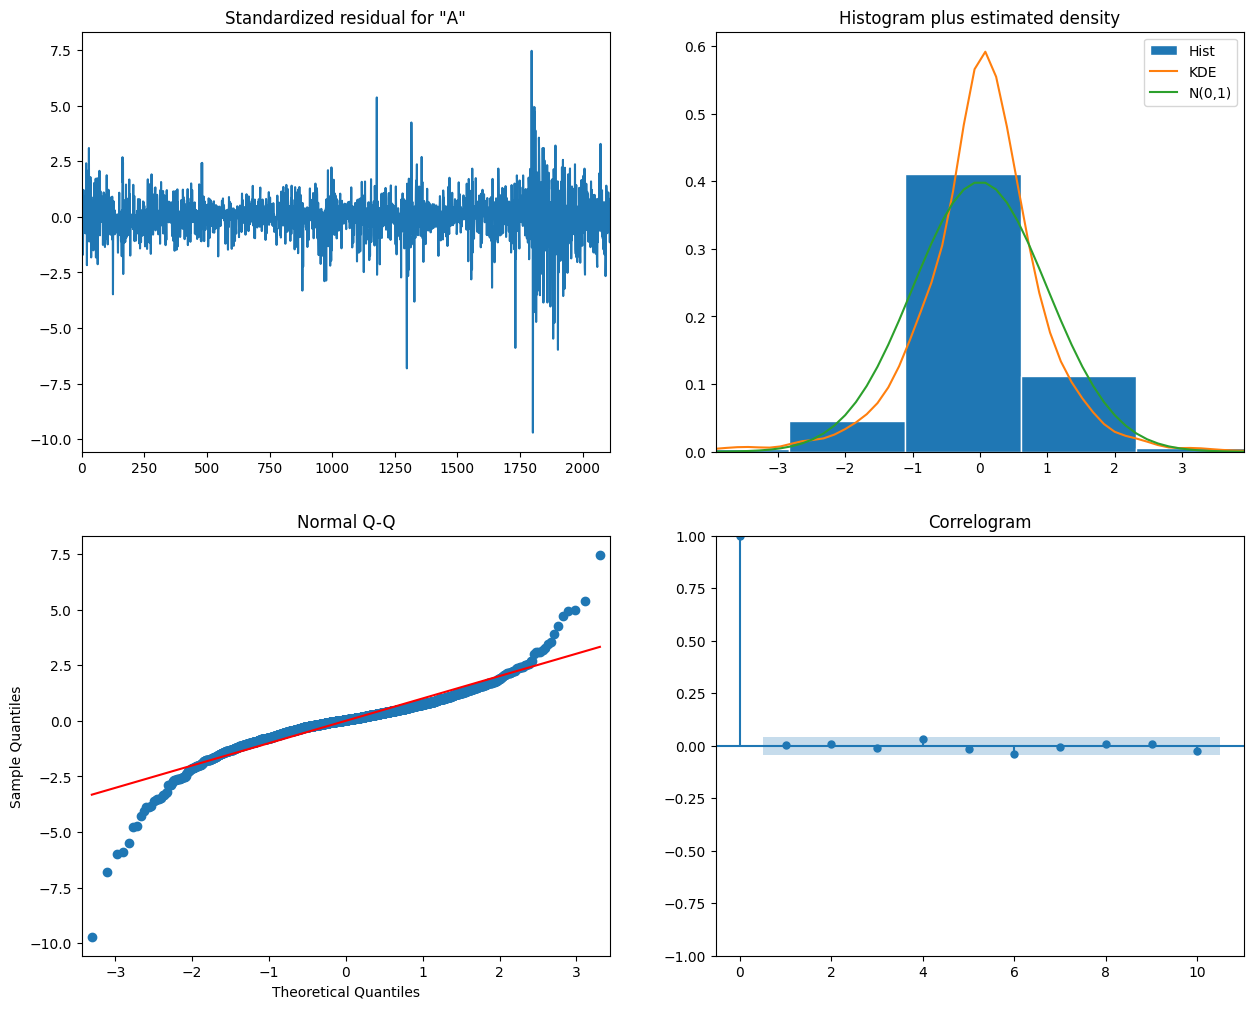

In [24]:
#Graficos de diagnostico para complementar el analisis
resultado.plot_diagnostics(figsize=(15, 12))
plt.show()

                 0
count  2111.000000
mean      0.038215
std       2.045937
min     -15.788932
25%      -0.688432
50%       0.070769
75%       0.796718
max      56.420000


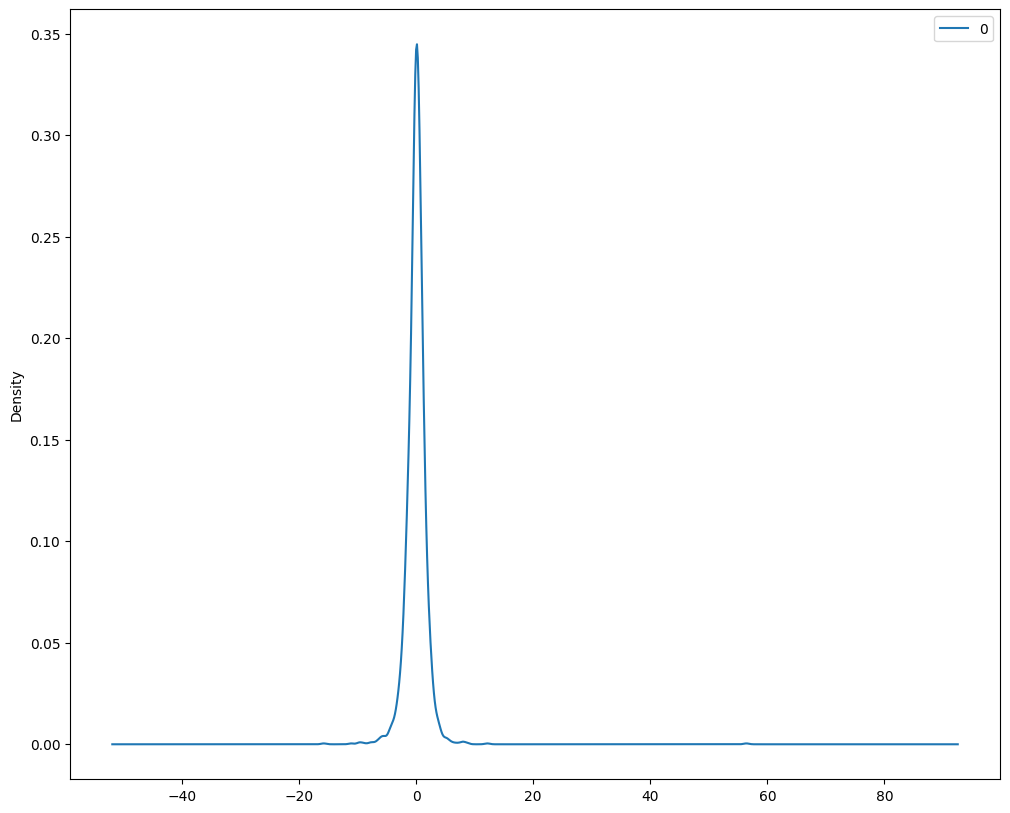

In [25]:
#Grafico de distribucion de los residuos y sus estadisticos relevantes
residuals = pd.DataFrame(resultado.resid)
residuals.plot(kind='kde')
print(residuals.describe())
plt.show()

#Predicción

In [26]:
#dividimos la serie en train y test
train, test = train_test_split(serie, train_size=0.8)

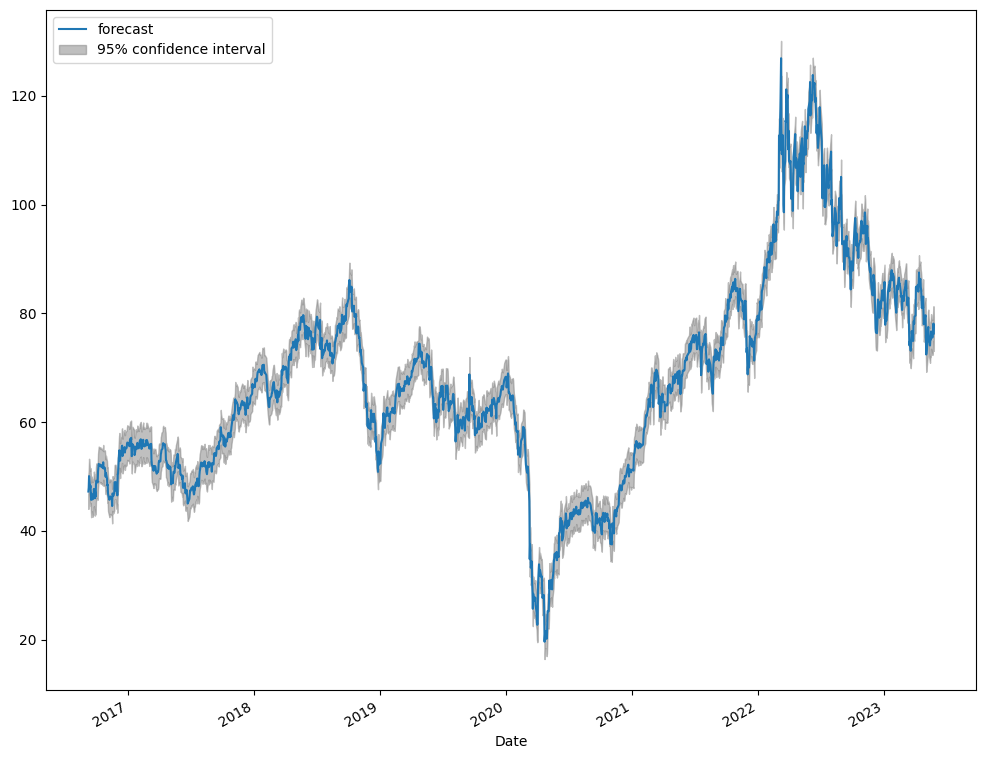

In [27]:
#Hacemos un grafico de la prediccion de toda la seria basada en el modelo seleccionado como optimo anteriormente y le agregamos un intervalo de confianza del 95%
plot_predict(resultado,start=len(test), dynamic = False)
plt.show()

In [28]:
#Hacemos una prediccion con el modelo de la parte que vamos a usar ver la eficacia de la prediccion
arima_pred = resultado.predict(start=len(train), end=len(serie)-1, typ='levels')
arima_pred

Date
2021-09-27    77.763034
2021-09-28    79.620401
2021-09-29    78.920699
2021-09-30    78.432593
2021-10-01    78.713609
                ...    
2023-05-22    75.540727
2023-05-23    75.886983
2023-05-24    77.039827
2023-05-25    78.122744
2023-05-26    76.293454
Name: predicted_mean, Length: 423, dtype: float64

In [29]:
#Estadisticos de los valores predichos respecto de los valores reales
arima_rmse_error = mean_squared_error(test['Adj Close**'], arima_pred, squared=False)
arima_mse_error = arima_rmse_error**2
mean_values = arima_pred.mean()
max_pred_value = arima_pred.max()
min_pred_value = arima_pred.min()


print('MSE Error:', arima_mse_error)
print('RMSE Error:', arima_rmse_error)
print('Mean:', mean_values)
print('Max predicted Value:', max_pred_value)
print('Min predicted value:', min_pred_value)

MSE Error: 1265.072802421623
RMSE Error: 35.567861932109764
Mean: 91.55894063842179
Max predicted Value: 126.92893174639131
Min predicted value: 68.78339237431885


Text(0.5, 1.0, 'Modelo ARIMA')

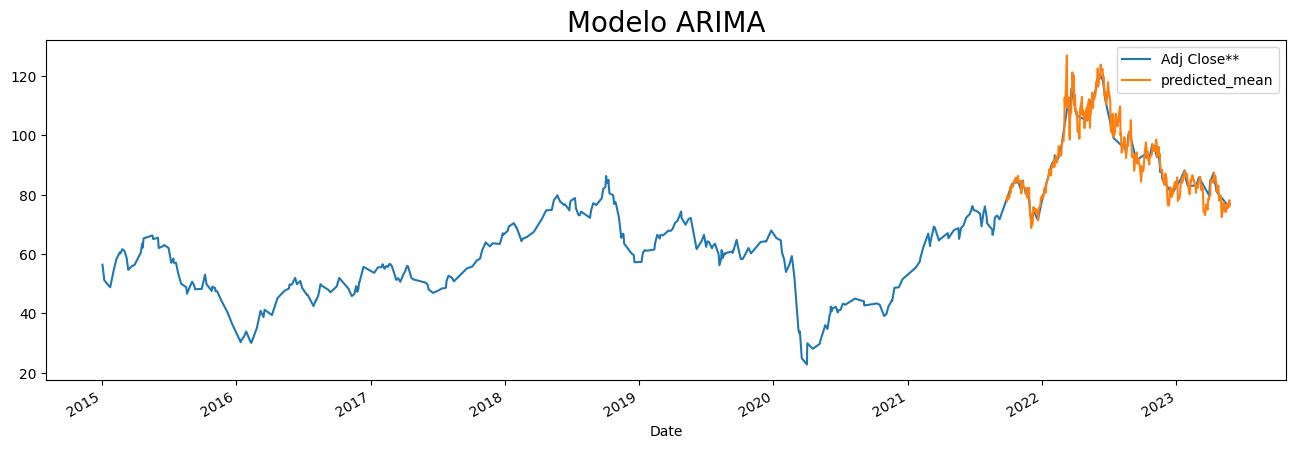

In [30]:
#Garfico de los valores predichos comparados con la serie original
test['Adj Close**'].plot(figsize=(16,5), legend=True)
arima_pred.plot(legend=True)
plt.title('Modelo ARIMA', fontsize=20)

In [31]:
#Prediccion de periodos que se pide en consigna
prediccion = resultado.get_forecast(steps=365)
mean_prediction = prediccion.predicted_mean
conf_int = prediccion.conf_int()
lower_limits = conf_int.loc[:,'lower Adj Close**']
upper_limits = conf_int.loc[:,'upper Adj Close**']

print(mean_prediction)

2111    77.011741
2112    76.884359
2113    76.959694
2114    76.938727
2115    76.868772
          ...    
2471    76.887638
2472    76.887638
2473    76.887638
2474    76.887638
2475    76.887638
Name: predicted_mean, Length: 365, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [32]:
#Estadisticos relevantes de la prediccion de consigna
mean_pred = mean_prediction.mean()
max_pred = mean_prediction.max()
min_pred = mean_prediction.min()
var_pred = mean_prediction.var()

print('la media de las predicciones pedidas por consigna es {}'. format(mean_pred))
print('el maximo valor de las predicciones pedidas por consigna es {}'. format(max_pred))
print('el minimo valor de las predicciones pedidas por consigna es {}'. format(min_pred))
print('la varianza de las predicciones pedidas por consigna es {}'. format(var_pred))

la media de las predicciones pedidas por consigna es 76.88866323801764
el maximo valor de las predicciones pedidas por consigna es 77.01174078567148
el minimo valor de las predicciones pedidas por consigna es 76.8515819720615
la varianza de las predicciones pedidas por consigna es 0.0001335103843079979


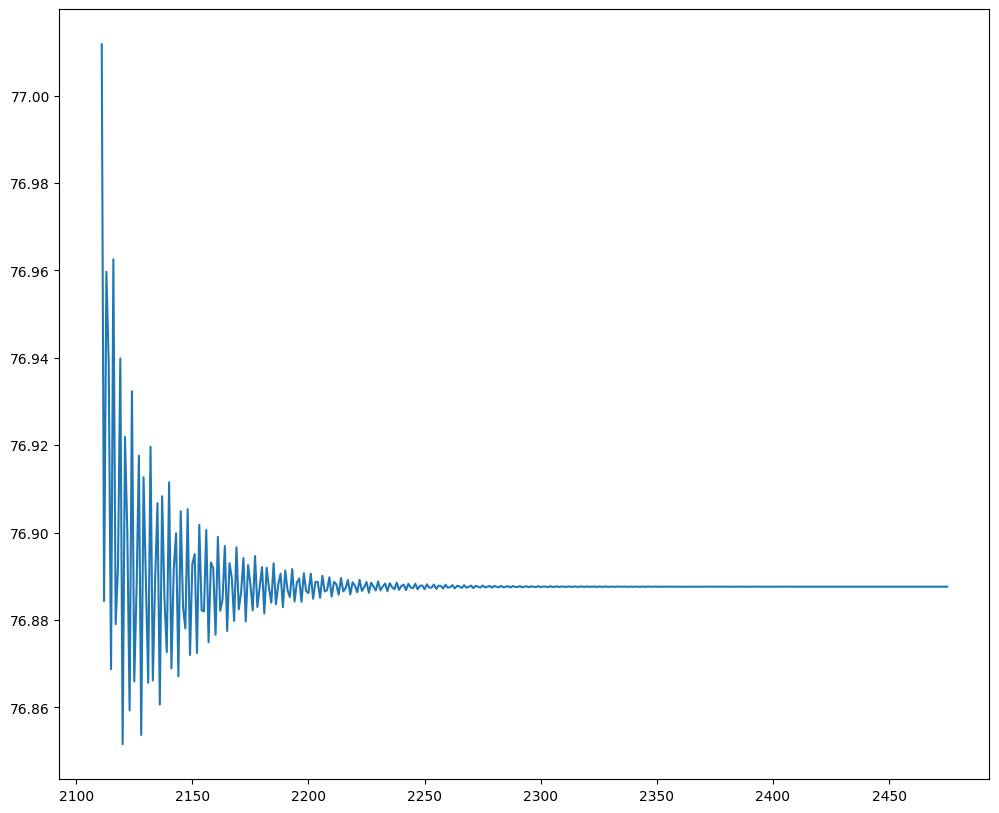

In [33]:
#Grafico de las predicted means para ver su tendencia
plt.plot(mean_prediction)
plt.show()

Podemos ver un grafico de los valores medios predichos que exceden los datos que se poseen. Vemos que van oscilando en torno a la media y se estabilizan.
Esto podemos pensar que es debido a que el modelo no tiene una capacidad de prediccion de tantos periodos. Es una limitacion que no se puede eludir por consigna.

In [34]:
predictions_df = pd.DataFrame({
    'Date': pd.date_range(start=serie.index[-1] + pd.DateOffset(days=1), periods=365),
    'Predicted_Value': mean_prediction.values
})
predictions_df
#Hacemos un dataframe de los valores predichos que exceden la serie

,Date,Predicted_Value
0,2023-05-27,77.011741
1,2023-05-28,76.884359
2,2023-05-29,76.959694
3,2023-05-30,76.938727
4,2023-05-31,76.868772
...,...,...
360,2024-05-21,76.887638
361,2024-05-22,76.887638
362,2024-05-23,76.887638
363,2024-05-24,76.887638


In [35]:
new_serie = serie.append(predictions_df.set_index('Date'))
new_serie
#juntamos la serie original con los datos que se predijeron

<ipython-input-35-d8fdda031512>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_serie = serie.append(predictions_df.set_index('Date'))


,Adj Close**,Predicted_Value
Date,,
2015-01-02,56.42,NaN
2015-01-05,53.11,NaN
2015-01-06,51.10,NaN
2015-01-07,51.15,NaN
2015-01-08,50.96,NaN
...,...,...
2024-05-21,NaN,76.887638
2024-05-22,NaN,76.887638
2024-05-23,NaN,76.887638


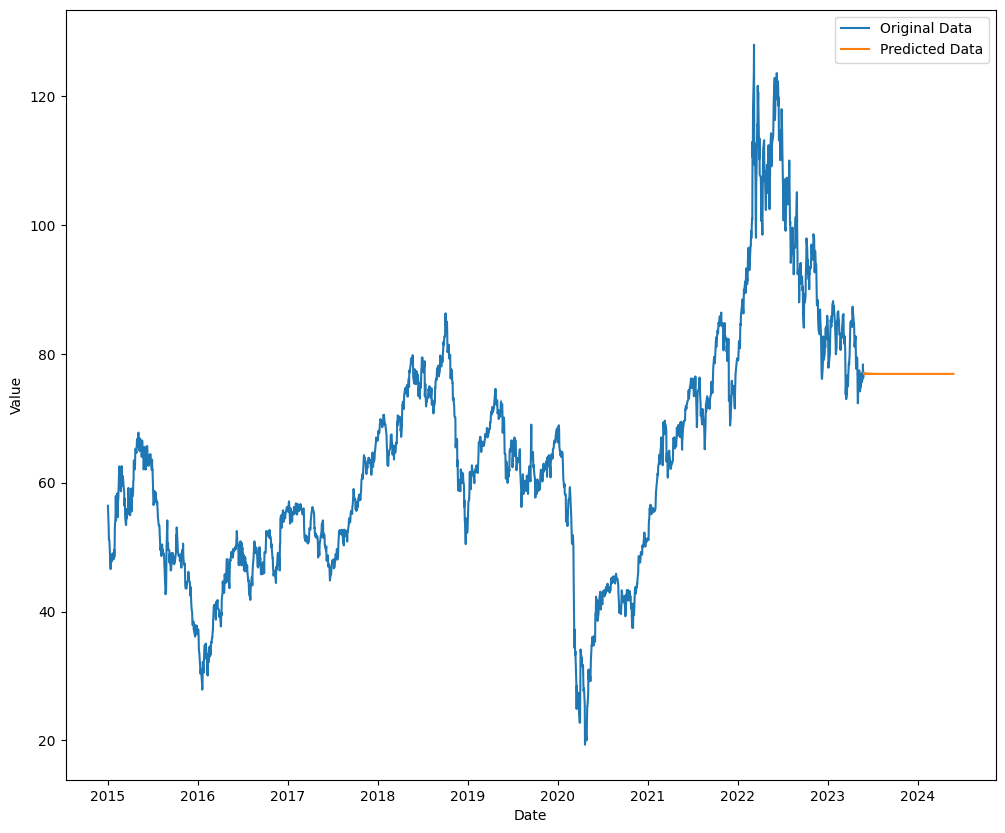

In [36]:
plt.plot(new_serie.index, new_serie['Adj Close**'], label='Original Data')
plt.plot(new_serie.index, new_serie['Predicted_Value'], label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
#grafico que junta valores reales con valores predichos con las limitaciones correspondientes del modelo

# Simulación

In [59]:
#semilla
np.random.seed(99)

## Punto 1

### Cartera 1

In [60]:
#Cartera 1
array = [0, 1, 2, 3]
f = [0.955, 0.03, 0.01, 0.005]
sin_totales=[]

for _ in range(5000):
  num_siniestros_1 = np.random.choice(a=array, p=f)
  sin_totales.append(num_siniestros_1)

suma_siniestros = np.sum(sin_totales)

sin_tipo_a = 0
sin_tipo_b = 0
mon_total_a=0
mon_total_b=0
monto_total_1=0

for siniestros in sin_totales:
  if np.random.random() > 0.45:
    sin_tipo_a+=siniestros
    monto_a=np.random.exponential(500_000, size=siniestros)
    mon_total_a+=np.sum(monto_a)
    monto_total_1+=np.sum(monto_a)
  else:
    sin_tipo_b+=siniestros
    monto_b=np.random.normal(350_000, 100_000)
    mon_total_b+=siniestros*monto_b
    monto_total_1+=siniestros*monto_b
    monto_b *=0.9

e_cartera = monto_total_1
desv_cartera = np.sqrt((mon_total_a**2 + mon_total_b**2)/ len(sin_totales))
prima_riesgo_1 = e_cartera + 1.5*desv_cartera

print('La prima de riesgo de la cartera 1 es de: {}'.format(prima_riesgo_1))

La prima de riesgo de la cartera 1 es de: 135251667.4920095


### Cartera 2

In [61]:
#Saco el lambda mediante los datos historicos
datos_historicos = pd.read_excel('/content/Simulación.xlsx')
print(datos_historicos)

    Años  Cantidad_de_Pólizas  Cantidad_de_siniestros
0   2010                 8900                     188
1   2011                 9400                     183
2   2012                11250                     225
3   2013                12000                     240
4   2014                10800                     205
5   2015                10500                     210
6   2016                 9800                     196
7   2017                11200                     224
8   2018                12700                     258
9   2019                11900                     248
10  2020                10300                     200
11  2021                 9600                     192
12  2022                12000                     231


In [62]:
datos_historicos['lambda'] = datos_historicos['Cantidad_de_siniestros']/datos_historicos['Cantidad_de_Pólizas']
print(datos_historicos)

    Años  Cantidad_de_Pólizas  Cantidad_de_siniestros    lambda
0   2010                 8900                     188  0.021124
1   2011                 9400                     183  0.019468
2   2012                11250                     225  0.020000
3   2013                12000                     240  0.020000
4   2014                10800                     205  0.018981
5   2015                10500                     210  0.020000
6   2016                 9800                     196  0.020000
7   2017                11200                     224  0.020000
8   2018                12700                     258  0.020315
9   2019                11900                     248  0.020840
10  2020                10300                     200  0.019417
11  2021                 9600                     192  0.020000
12  2022                12000                     231  0.019250


In [63]:
lam = 0.02*2
siniestros_poisson = np.random.poisson(lam, size=10_000)
cant_sin_2 = siniestros_poisson.sum()
beta = 1/0.000001997
#simulacion de montos
expon_sin_trunc = np.random.exponential(beta, cant_sin_2)
expon_con_trunc = np.where(expon_sin_trunc > 600_000, 600_000, expon_sin_trunc)
expon_con_trunc_1 = np.where(expon_con_trunc < 75_000, 75_000, expon_con_trunc)

print('La suma de los montos de la cartera 2 es de: {}'.format(np.sum(expon_con_trunc_1)))
media_montos_2 = np.mean(expon_con_trunc_1)*cant_sin_2
desv_montos_2 = np.std(expon_con_trunc_1)*cant_sin_2
print(media_montos_2)
print(desv_montos_2)

montos_2 = expon_con_trunc_1*cant_sin_2


La suma de los montos de la cartera 2 es de: 152899477.88298756
152899477.88298756
90585140.56632632


In [64]:
tridente=0
for i in range(cant_sin_2):
  tridente += (1/cant_sin_2)*((np.mean(montos_2)-np.std(montos_2))/np.mean(montos_2))

tridente

0.40755101442759756

In [65]:
prima_riesgo_2 = media_montos_2*(1+tridente)
print(prima_riesgo_2)

215213815.19964916


In [66]:
#Prima total
prima_total = prima_riesgo_1+prima_riesgo_2

print('La prima de riesgo total es de:{} '.format(prima_total))

La prima de riesgo total es de:350465482.6916586 


### Funciones auxiliares

In [67]:
#Definicion de funcion de simulacion solo de siniestros de cartera 1 para utilizar en el punto 2
def simulacion_cartera1():
    array = [0, 1, 2, 3]
    f = [0.955, 0.03, 0.01, 0.005]
    sin_totales = []

    for _ in range(5000):
        num_siniestros_1 = np.random.choice(a=array, p=f)
        sin_totales.append(num_siniestros_1)

    sin_tipo_a = 0
    sin_tipo_b = 0
    montos_totales = []

    for siniestros in sin_totales:
        if np.random.random() > 0.45:
            sin_tipo_a += siniestros
            montos_a = np.random.exponential(500_000, size=siniestros)
            montos_totales.extend(montos_a)
        else:
            sin_tipo_b += siniestros
            monto_b = np.random.normal(350_000, 100_000)
            montos_b = [monto_b] * siniestros
            montos_totales.extend(montos_b)

    suma_montos = np.sum(montos_totales)

    return suma_montos

In [68]:
#Definicion de funcion de generacion de montos para la cartera 2 de forma auxiliar para el punto

def simulacion_montos2():
    lam = 0.02 * 2
    siniestros_poisson = np.random.poisson(lam, size=10_000)
    cant_sin_2 = siniestros_poisson.sum()
    beta = 1 / 0.000001997

    # Simulación de montos
    expon_sin_trunc = np.random.exponential(beta, cant_sin_2)
    expon_con_trunc = np.where(expon_sin_trunc > 600_000, 600_000, expon_sin_trunc)
    expon_con_trunc_1 = np.where(expon_con_trunc < 75_000, 75_000, expon_con_trunc)

    suma_montos_2 = np.sum(expon_con_trunc_1)
    media_montos_2 = np.mean(expon_con_trunc_1) * cant_sin_2
    desv_montos_2 = np.std(expon_con_trunc_1) * cant_sin_2

    montos_aux = expon_con_trunc_1 * cant_sin_2
    montos_2 = np.mean(montos_aux)

    return montos_2

## Punto 2

### Inciso a

In [69]:
def simular_año(capital_inicial):

   ingreso_primas = capital_inicial
   mitad_ingreso = ingreso_primas/2

   #Ingresos
   rent_alta_inic = np.random.exponential(0.2)
   rent_alta_trunc = np.where(rent_alta_inic >0.4, 0.4, rent_alta_inic)
   rent_alta_porc = np.where(rent_alta_trunc < -0.15, -0.15, rent_alta_trunc)
   rent_alta = mitad_ingreso*(1+rent_alta_porc)

   rent_baja = mitad_ingreso*(1+0.05)

   ingreso = rent_alta + rent_baja

   #Gastos
   costos_fijos = np.random.uniform(low=35_000_000, high=50_000_000)
   costos_variables = (np.random.lognormal(1.5, 0.75)*2_000_000)
   siniestralidad = simulacion_cartera1() + simulacion_montos2()

   costo_total = costos_fijos + costos_variables + siniestralidad

   #Ganancias
   result_antes_imp = ingreso - costo_total

   #impuesto
   impuesto = 0.3*result_antes_imp

   result_desp_imp = result_antes_imp - impuesto

   #Dividendos
   if result_desp_imp > 0:
    dividendos = np.random.choice(a=[0.05, 0.1, 0.15, 0.2], p=[0.25, 0.30, 0.35, 0.10])
    pago_div = result_desp_imp*dividendos
   else:
    dividendos = 0
    pago_div = result_desp_imp*dividendos

  #Resultado neto
   resultado_neto = round(result_desp_imp - pago_div, 2)

   return resultado_neto

In [70]:
print(simular_año(prima_total))

50376687.47


In [71]:
def simular_3_años(capital_inicial):
    resultados = []

    for _ in range(3):
        resultado_año = simular_año(capital_inicial)
        resultados.append(resultado_año)
        capital_inicial += resultado_año

    resultado_total = np.sum(resultados)
    media_resultados = np.mean(resultados)
    desviacion_resultados = np.std(resultados)

    return resultado_total, media_resultados, desviacion_resultados, resultados

In [72]:
simulacion_consigna = simular_3_años(prima_total)

In [73]:
print('La media de los resultados es de {}'.format(simulacion_consigna[1]))
print('El desvio de los resultados es de {}'.format(simulacion_consigna[2]))

La media de los resultados es de 60822704.02
El desvio de los resultados es de 32710940.606264282


### Inciso b

In [74]:
def simular_varias_veces(iteraciones, capital_inicial):
    lista_medias = []

    for _ in range(iteraciones):
        _, media_resultados, _, _ = simular_3_años(capital_inicial)
        lista_medias.append(media_resultados)

    return lista_medias

In [75]:
simulacion_inciso_b = simular_varias_veces(100, prima_total)

prob_1 = np.where(np.array(simulacion_inciso_b) > 120_000_000, 1, 0).sum() / 100
prob_2 = np.where((np.array(simulacion_inciso_b) > 90_000_000) & (np.array(simulacion_inciso_b) < 50_000_000), 1, 0).sum() / 100
prob_3 = prob_2 = np.where(np.array(simulacion_inciso_b) < 0, 1, 0).sum() / 100

In [76]:
print('La probabilidad de que el resultado sea mayor que 120.000.000 es de {}'.format(prob_1))
print('La probabilidad de que el resultado este entre 50.000.000 y 90.000.000 es de {}'.format(prob_2))
print('La probabilidad de que el resultado sea menor a 0 es de {}'.format(prob_3))

La probabilidad de que el resultado sea mayor que 120.000.000 es de 0.0
La probabilidad de que el resultado este entre 50.000.000 y 90.000.000 es de 0.0
La probabilidad de que el resultado sea menor a 0 es de 0.0


### Inciso c

In [77]:
#Simulacion y grafico de al menos 5 trayectorias
def simular_varias_trayectorias(iteraciones, capital_inicial):
    lista_resultados = []

    for _ in range(iteraciones):
        _, _, _, resultados = simular_3_años(capital_inicial)
        lista_resultados.append(resultados)

    # Graficar las trayectorias
    for trayectoria in lista_resultados:
        plt.plot(range(len(trayectoria)), trayectoria, marker='o')

    plt.xlabel('Años')
    plt.ylabel('Resultado')
    plt.title('Trayectorias de Simulación')
    plt.show()

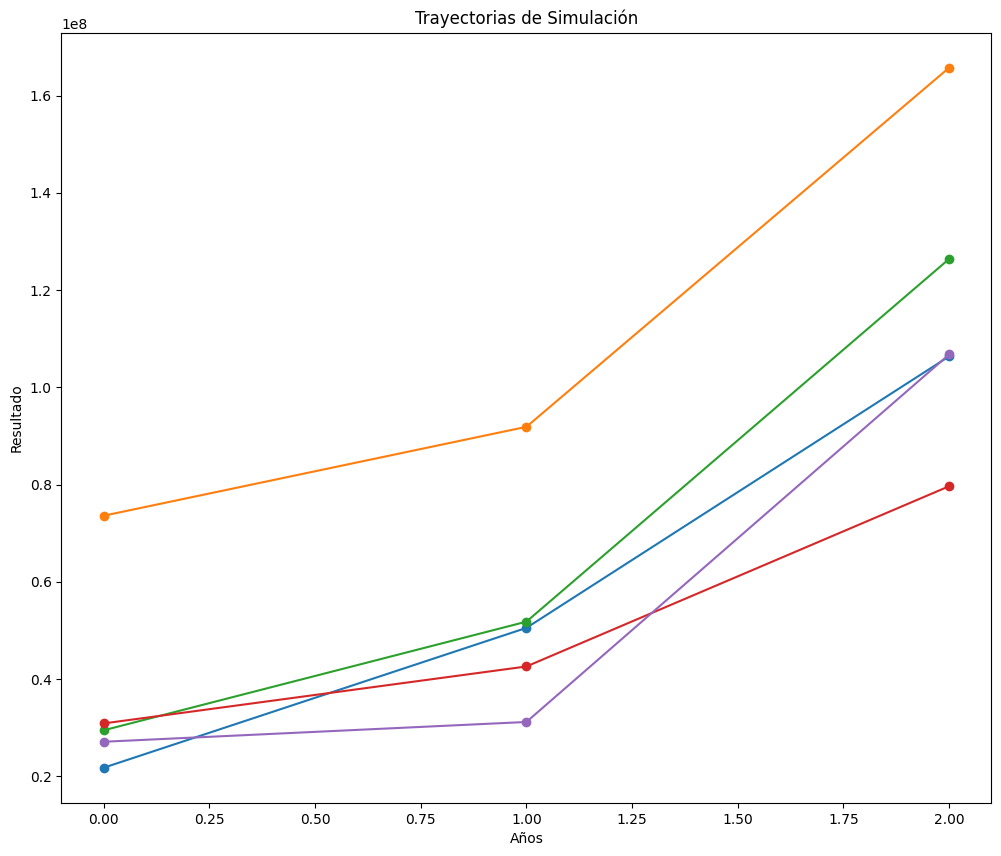

In [78]:
simular_varias_trayectorias(5, prima_total)

In [79]:
#Grafico de la distribucion
def generar_grafico_distribucion(iteraciones, capital_inicial):
    lista_resultados = []

    for _ in range(iteraciones):
        _, _, _, resultados = simular_3_años(capital_inicial)
        lista_resultados.extend(resultados)

    # Generar gráfico de distribución
    plt.hist(lista_resultados, bins='auto', edgecolor='black')
    plt.xlabel('Resultado')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Resultados')
    plt.show()

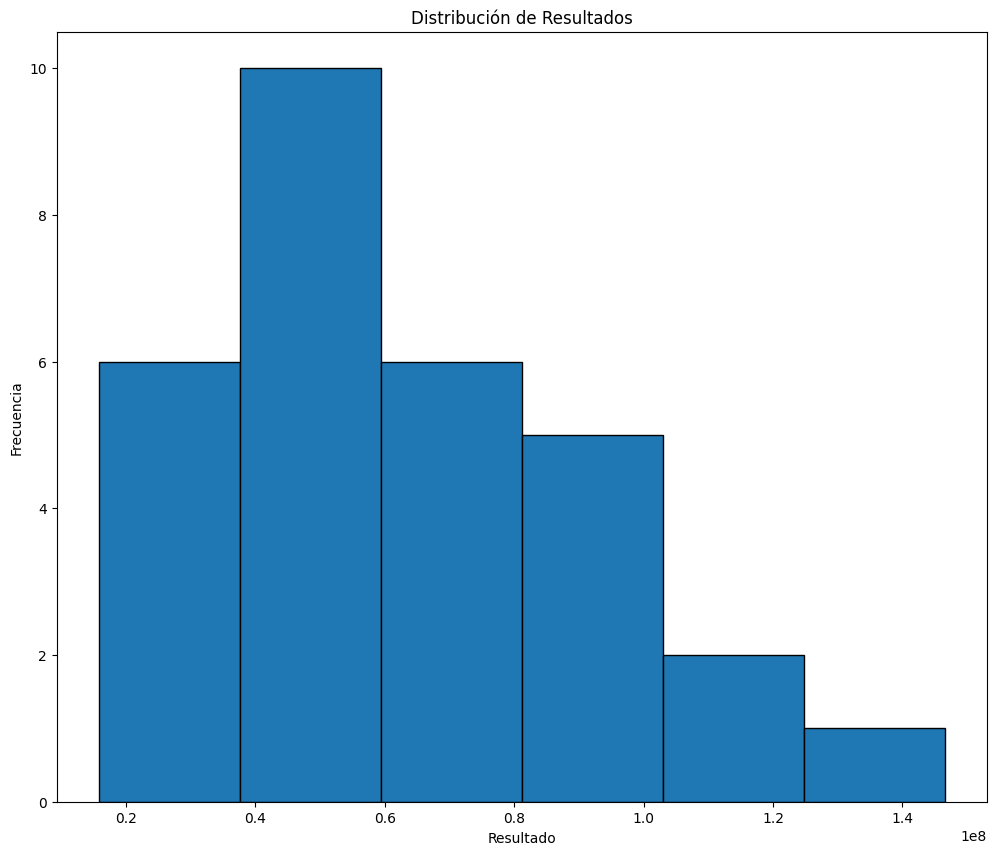

In [80]:
generar_grafico_distribucion(10, prima_total)